<a href="https://colab.research.google.com/github/hijunshi/deep-learning-engineer/blob/homeworks_submission/%EC%9D%B4%EC%A4%80%EC%84%B1_kmeans_implemented_by_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 ╔══<i><b>&nbsp;Alai-DeepLearning&nbsp;</b></i>══════════════════════════════════╗
###  &nbsp;&nbsp; **✎&nbsp;&nbsp;Week 4. Tensorflow basis**
# Homework 2. Tensorflow로 K-Means 구현하기

### _Objective_
1. Tensorflow 을 이용해서 K-Means 알고리즘을 구현합니다.


╚═══════════════════════════════════════════════╝

In [0]:
%matplotlib inline
import tensorflow as tf 
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

<br>
<br>
## 예제 데이터셋 )

In [0]:
# 예제 데이터셋 준비하기
!wget https://s3.ap-northeast-2.amazonaws.com/pai-datasets/alai-deeplearning/kmeans_dataset.txt
dataset = np.loadtxt("./kmeans_dataset.txt")

--2019-07-10 11:52:00--  https://s3.ap-northeast-2.amazonaws.com/pai-datasets/alai-deeplearning/kmeans_dataset.txt
Resolving s3.ap-northeast-2.amazonaws.com (s3.ap-northeast-2.amazonaws.com)... 52.219.60.49
Connecting to s3.ap-northeast-2.amazonaws.com (s3.ap-northeast-2.amazonaws.com)|52.219.60.49|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1520 (1.5K) [text/plain]
Saving to: ‘kmeans_dataset.txt’

kmeans_dataset.txt  100%[===================>]   1.48K  --.-KB/s    in 0s      

2019-07-10 11:52:00 (57.8 MB/s) - ‘kmeans_dataset.txt’ saved [1520/1520]



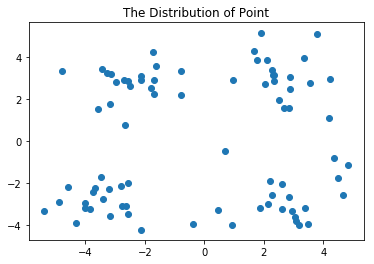

In [0]:
# 예제 데이터셋 시각화
plt.title("The Distribution of Point")
plt.scatter(dataset[:,0],dataset[:,1])
plt.show()

<br>
<br>
##  알고리즘 탐색하기
---
K-means의 알고리즘 순서 

1. 초기 중심점을 설정하기 위해 K개의 점 생성(일반적으로 임의)
2. 중심점과 각 데이터 사이의 거리를 계산
3. 각 데이터를 거리가 가장 가까운 군집으로 할당
4. 각 군집 별 점들의 평균을 계산 후, 군집의 중심점을 다시 계산
5. 2~4의 과정을 통해 각 데이터 별 군집이 바뀌지 않았으면, 이 과정을 끝냄

아래 코드는 Numpy 로 K-means 을 구현한 코드 입니다.<br>

---

In [0]:
def cluster_kmeans(dataset, k):    
    # (1) 중심점 초기화
    min_x = dataset[:,0].min()
    max_x = dataset[:,0].max() 
    min_y = dataset[:,1].min()
    max_y = dataset[:,1].max() 

    center_x = np.random.uniform(low=min_x, high=max_x, size=k)
    center_y = np.random.uniform(low=min_y, high=max_y, size=k)
    centroids = np.stack([center_x,center_y],axis=-1)
    
    # (2) ~ (5) 순회
    num_data = dataset.shape[0]
    cluster_per_point = np.zeros((num_data)) # 각 점 별 군집

    counter = 0
    while True:
        prev_cluster_per_point = cluster_per_point
        
        # (2) 거리 계산
        diff_mat = (centroids.reshape(-1,1,2) - dataset.reshape(1,-1,2))
        dists = np.sqrt((diff_mat**2).sum(axis=-1))
        # (3) 각 데이터를 거리가 가장 가까운 군집으로 할당
        cluster_per_point = dists.argmin(axis=0)
        
        # (4) 각 군집 별 점들의 평균을 계산 후, 군집의 중심점을 다시 계산
        for i in range(k):
            centroids[i] = dataset[cluster_per_point==i].mean(axis=0)

        if np.all(prev_cluster_per_point == cluster_per_point):
            break

        counter += 1
        plt.title("{}th Distribution of Dataset".format(counter))
        for idx, color in enumerate(['r','g','b','y']):
            mask = (cluster_per_point==idx)
            plt.scatter(dataset[mask,0],dataset[mask,1],
                        label='dataset', c=color)
            plt.scatter(centroids[:,0],centroids[:,1],
                        s=200, label="centroid", marker='+')
        plt.show()
    
    return centroids

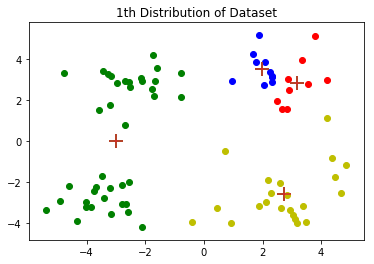

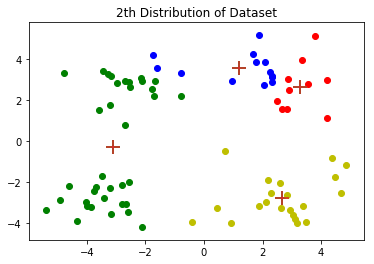

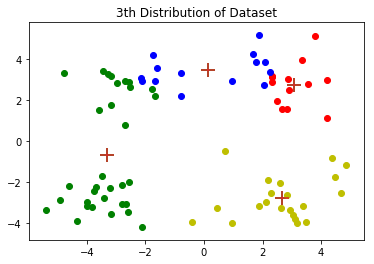

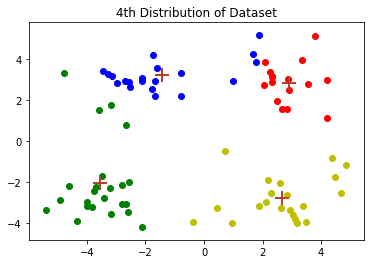

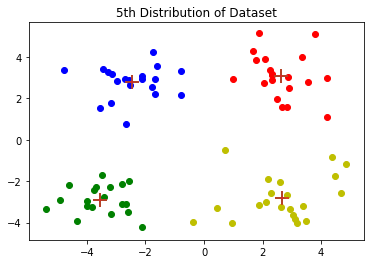

array([[ 2.6265299 ,  3.10868015],
       [-3.53973889, -2.89384326],
       [-2.46154315,  2.78737555],
       [ 2.65077367, -2.79019029]])

In [0]:
cluster_kmeans(dataset, 4)

## \[ 문제 : 텐서플로우를 이용해 K-Means 구현하기 \]

텐서플로우는 numpy와 달리, Dataflow Programming 방식으로 동작합니다. <br>
우선 연산을 결정하고, 반복적인 연산은 Session 시에 진행해야 합니다.<br>



In [0]:

# tensor로 바꿈
dataset_tf = tf.constant(dataset)
k = 4

min_x = tf.math.reduce_min(dataset_tf[:,0])
max_x = tf.math.reduce_max(dataset_tf[:,0])
min_y = tf.math.reduce_min(dataset_tf[:,1])
max_y = tf.math.reduce_max(dataset_tf[:,1])

# 임의의 중심값 생성
center_x = tf.random.uniform(shape=[k], minval=min_x, maxval=max_x,dtype='float64')
center_y = tf.random.uniform(shape=[k], minval=min_y, maxval=max_y,dtype='float64')
centroids = tf.stack([center_x, center_y], axis=-1)
centroids = tf.cast(centroids, tf.float64)

# 중심값과의 거리계산
diff_mat = tf.subtract(tf.reshape(centroids, [-1,1,2]), tf.reshape(dataset_tf, [1,-1,2]))
dists = tf.sqrt(tf.reduce_sum(tf.square(diff_mat), axis=1))
# 3. 각 데이터를 거리가 가장 가까운 군집으로 할당 
# cluster_per_point-> 제일 작은 x,y값의 인덱스가 넘어온다.
cluster_per_point = tf.argmin(dists, axis=0)


# 4. 각 군집별 점들의 평균을 계산한 후, 군집의 중심점을 다시 계산
with tf.Session() as sess:
    for i in range(k):
        means = tf.concat([tf.reduce_mean(
                              tf.gather(
                                  dataset_tf, tf.reshape(
                                      tf.where(
                                          # x,y가 i 군집에 해당하는지 bool값으로 넘어온다.
                                          tf.equal(
                                              cluster_per_point,i
                                              )
                                          ),[1,-1]
                                      )
                                  ), axis=[1]
                              )],0
                          )
    update_centroids = tf.assign(ref=centroids, value=means)

    for idx, color in enumerate(['r','g','b','y']):
        mask = tf.equal(cluster_per_point, idx)
        plt.scatter(dataset_tf[mask,0], dataset_tf[mask,1],
                    label='dataset', c=color)
        plt.scatter(centroids[:,0], centroids[:,1],
                    s=200, label='centroid', marker='+')
        plt.show()

    sess.run(tf.initialize_all_variables())
    sess.run(update_centroids)

AttributeError: ignored